
# List 1

Krzysztof Jankowski


## Imports


In [1]:
import numpy as np
from pydantic import validate_call, PositiveInt
from enum import Enum, auto
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import logging
from functools import lru_cache, cache
from utils import with_pickle

In [2]:
logger = logging.getLogger(__name__)

In [3]:
class State(Enum):
    positive = auto()
    negative = auto()

c0 <- initial concentration

c+ <- positive opinion

c- <- negative opinion

$$
c^+=\frac{1}{N}\sum^N_{i-1}\frac{(S_i+1)}{2}\in\bigl[0,1\bigr]
$$

$$
c^-=1-c^+
$$
$$
Pr(S_i(t=0)=1)=c_0
$$

In [4]:
class SznajdModel:
    @validate_call
    def __init__(self, n: int, t: int, c0: float) -> None:
        self.n = n
        self.t = t
        self.c0 = c0
    
    def run(self):
        self._pre_init_simulation()
        for i in range(self.t):
            self._update(i)
        
    def _pre_init_simulation(self) -> None:
        #Optimization stuff
        self.graph = self._init_graph()
        self.choice = np.random.randint(low=0, high=self.n-1, size=(self.t, self.n))
    
    def _init_graph(self) -> np.ndarray[State]:
        init = np.random.choice(list(State), size=self.n, p=[self.c0, 1 - self.c0])
        graph_evolution = np.ndarray((self.t+1, self.n), dtype=State)
        graph_evolution[0,:] = init
        return graph_evolution
    
    def _update(self, step: PositiveInt):
        """Each update corresponds with n atomic updates. From the other side we 
        store simulation in frame (t + 1 x n) that means we apply for each row 
        state after n atomic updates.
        
        In that case, at first, we copy state (row) from the previous update or 
        init state, to the current updated row. Have in mind that first row is 
        an initial state. Therefore i-th update row corresponds with i-th + 1
        graph evolution row. 
        """
        self.graph[step+1,:] = self.graph[step,:]
        for substep in self.choice[step]:
            if self.graph[step+1][substep] == self.graph[step+1][(substep + 1) % self.n]:
                self._agreement_update(step+1, substep)
            else:
                self._disagreement_update(step+1, substep)
            
    
    def _agreement_update(self, step: int, pos: int) -> None:
        state = self.graph[step][pos]
        self.graph[step, (pos - 1) % self.n] = state
        self.graph[step, (pos + 2) % self.n] = state
    
    def _disagreement_update(self, step: int, pos: int) -> None:
        self.graph[step][(pos - 1) % self.n] = self.graph[step][(pos + 1) % self.n]
        self.graph[step][(pos + 2) % self.n] = self.graph[step][pos]
    
    def get_graph_evolution(self) -> np.ndarray:
        return np.vectorize(lambda x: x.value)(self.graph)


In [5]:
class SznajdModel_v2(SznajdModel):
    """Do nothing variant"""
    def _disagreement_update(self, step: int, pos: int) -> None: ...
    

In [6]:
def task_2() -> None:
    n = 100
    t = 100
    c_inits = [0.25, 0.5, 0.75]
    
    fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey=True, sharex=True)
    for idx, c in enumerate(c_inits):
        model = SznajdModel(n, t, c)
        model.run()
        
        current_ax = axes.flatten()[idx]
        current_ax.imshow(model.get_graph_evolution(), cmap='viridis', interpolation='nearest')
        current_ax.set_title(f"USDF, $c_0={c}$")

    for idx, c in enumerate(c_inits):
        model = SznajdModel_v2(n, t, c)
        model.run()
        
        current_ax = axes.flatten()[idx + 3]
        current_ax.imshow(model.get_graph_evolution(), cmap='viridis', interpolation='nearest')
        current_ax.set_title(f"Do nothing, $c_0={c}$")
        current_ax.set_xlabel("State")
    axes.flatten()[0].set_ylabel("T")
    axes.flatten()[4].set_ylabel("T")
    fig.suptitle("Sznajd Model evolution")
    fig.tight_layout()
        

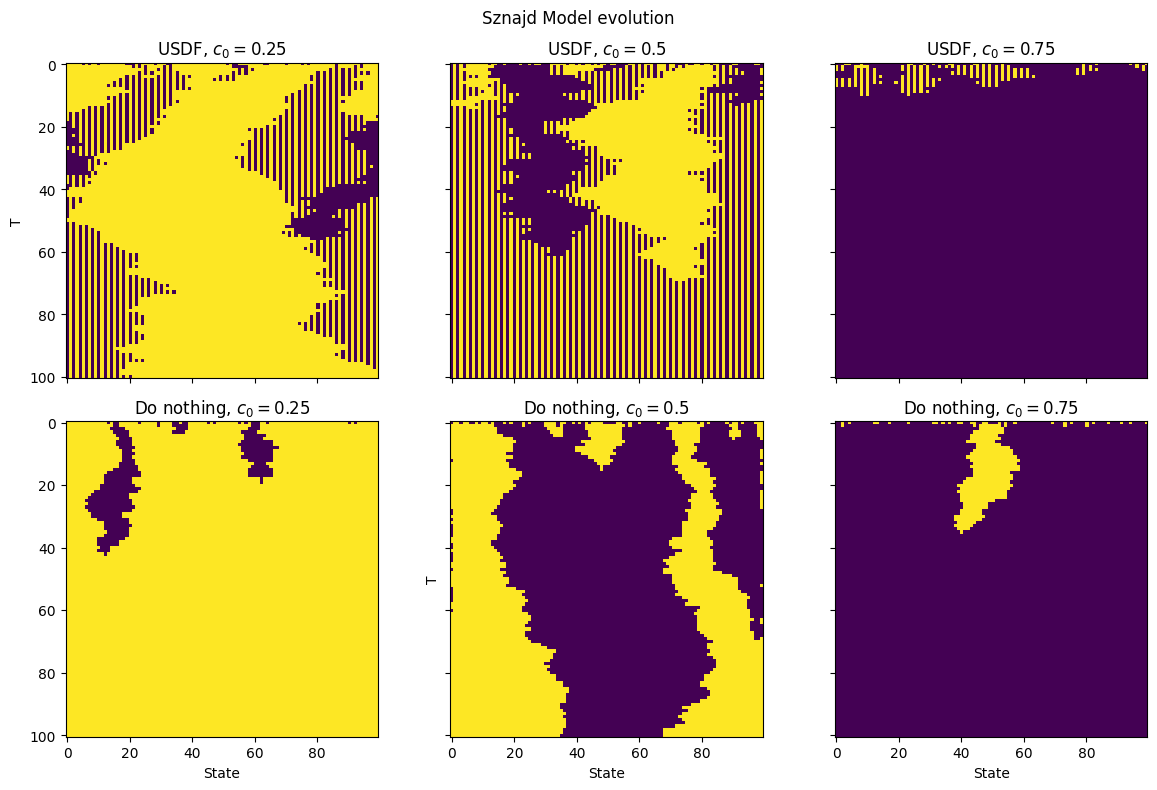

In [7]:
task_2()

In [7]:
class SteadyState(Enum):
    negative = auto()
    positive = auto()
    disagreement = auto()

In [8]:
class SznajdModel_v3(SznajdModel):
    
    def run_since_steady(self):
        """In that case t is used as a buffer size to, do not overwrite list 
        for each time. It is not a graceful feature, but reusing already 
        existing dimension.
        """
        self._pre_init_simulation()
        i = 0
        while not self._is_steady_state(i):
            self._update(i)
            i += 1
        self.steps_since_steady = i
        
    def get_steady_state(self) -> SteadyState:
        state = self.graph[(self.steps_since_steady) % (self.t  + 1), :]
        if all(s == State.positive for s in state):
            return SteadyState.positive
        elif all(s == State.negative for s in state):
            return SteadyState.negative
        elif (
            all(state[0] == s for s in state[::2])
            and all(state[1] == s for s in state[1::2])
        ):
            return SteadyState.disagreement
    
    def _is_steady_state(self, step: int) -> bool:
        state = self.graph[step % (self.t + 1), 0]
        all_agree = all(state == s for s in self.graph[step % (self.t + 1), :])
        state2 = self.graph[step % (self.t + 1), 1]
        all_disagree = (
            all(state == s for s in self.graph[step % (self.t + 1), ::2])
            and all(state2 == s for s in self.graph[step % (self.t + 1), 1::2])
        )
        return all_agree or all_disagree
    
    def _update(self, step: PositiveInt):
        """Each update corresponds with n atomic updates. From the other side we 
        store simulation in frame (t + 1 x n) that means we apply for each row 
        state after n atomic updates.
        
        In that case, at first, we copy state (row) from the previous update or 
        init state, to the current updated row. Have in mind that first row is 
        graph evolution row.
        
        In this case we unify this update to allow endless operating since 
        steady state exciding. If the time axis is overriden we reiterate. 
        """
        if step >= len(self.graph):
            self._clear_cache()
        self.graph[(step+1) % (self.t + 1),:] = self.graph[step % (self.t + 1),:]
        for substep in self.choice[step % self.t]:
            if self.graph[(step+1) % (self.t + 1), substep] == self.graph[(step+1) % (self.t + 1), (substep + 1) % self.n]:
                self._agreement_update((step+1) % (self.t + 1), substep)
            else:
                self._disagreement_update((step+1) % (self.t + 1), substep)
            
    
    def _clear_cache(self):
        self.graph[0,:] = self.graph[self.t, :]
        self.choice = np.random.randint(low=0, high=self.n-1, size=(self.t, self.n))


In [9]:
class SznajdModel_v4(SznajdModel_v3):
    """Do nothing variant"""
    def _disagreement_update(self, step: int, pos: int) -> None: ...
    

In [10]:
def _get_steady_sates__no_cache(n: int, c_inits: np.ndarray, runs_count: int):
    buffer_size = 100
    runs_ucdf = defaultdict(list)
    runs_dn = defaultdict(list)
    for c in c_inits:
        print(f"Running simulations for c={c}...")
        model_ucdf = SznajdModel_v3(n=n, t=buffer_size, c0=c)
        model_dn = SznajdModel_v4(n=n, t=buffer_size, c0=c)
        for _ in tqdm(range(runs_count)):
            model_ucdf.run_since_steady()
            runs_ucdf[c].append(model_ucdf.get_steady_state())
        for _ in tqdm(range(runs_count)):
            model_dn.run_since_steady()
            runs_dn[c].append(model_dn.get_steady_state())
        
    return {"dn": runs_dn, "ucdf": runs_ucdf}


@lru_cache(maxsize=9)
def _get_steady_sates__cache(n: int, c_inits_tuple: tuple, runs_count: int):
    c_inits = np.array(c_inits_tuple)
    return _get_steady_sates__no_cache(n, c_inits, runs_count)

In [11]:
def task3(cache: bool = True):
    n = 100
    runs_count = 100
    c_inits = np.arange(0.0, 1.001, 0.05)
    
    runs = (
        _get_steady_sates__cache(n, tuple(c_inits), runs_count) if cache
        else _get_steady_sates__no_cache(n, c_inits, runs_count)
    )
    ucdf_means: dict[str, float] = {}
    dn_means: dict[str, float] = {}
    for state in SteadyState:
        ucdf_means[state.name] = dict(map(lambda kv: (kv[0], np.sum(np.fromiter((s==state for s in kv[1]), dtype=float) / len(kv[1]))), runs["ucdf"].items()))
        dn_means[state.name] = dict(map(lambda kv: (kv[0], np.sum(np.fromiter((s==state for s in kv[1]), dtype=float) / len(kv[1]))), runs["dn"].items()))
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    ax_ucdf = axs.flatten()[0]
    _plot_states(ucdf_means, "positive", ax_ucdf, label="+", c="g")
    _plot_states(ucdf_means, "negative", ax_ucdf, label="-", c="r")
    _plot_states(ucdf_means, "disagreement", ax_ucdf, label="?", c="b")
    ax_ucdf.legend(title="State")
    ax_ucdf.grid(alpha=.5)
    ax_ucdf.set_xlabel("$c_0$")
    ax_ucdf.set_ylabel("Frequency")
    ax_ucdf.set_title("UCDF")
    
    ax_dn = axs.flatten()[1]
    _plot_states(dn_means, "positive", ax_dn, label="+", c="g")
    _plot_states(dn_means, "negative", ax_dn, label="-", c="r")
    _plot_states(dn_means, "disagreement", ax_dn, label="?", c="b")
    ax_dn.legend(title="State")
    ax_dn.grid(alpha=.5)
    ax_dn.set_xlabel("$c_0$")
    ax_dn.set_ylabel("Frequency")
    ax_dn.set_title("Do nothing")
    

def _plot_states(data, state, ax, *args, **kwargs):
    xs, ys = data[state].keys(), data[state].values()
    ax.plot(xs, ys, *args, **kwargs)

Running simulations for c=0.0...


100%|██████████| 100/100 [00:00<00:00, 9333.54it/s]


Running simulations for c=0.05...


100%|██████████| 100/100 [00:00<00:00, 1976.37it/s]


Running simulations for c=0.1...


100%|██████████| 100/100 [00:00<00:00, 186.95it/s]


Running simulations for c=0.15000000000000002...


100%|██████████| 100/100 [00:01<00:00, 51.84it/s]


Running simulations for c=0.2...


100%|██████████| 100/100 [00:02<00:00, 36.72it/s]


Running simulations for c=0.25...


100%|██████████| 100/100 [00:02<00:00, 34.66it/s]


Running simulations for c=0.30000000000000004...


100%|██████████| 100/100 [00:05<00:00, 18.57it/s]


Running simulations for c=0.35000000000000003...


100%|██████████| 100/100 [00:06<00:00, 14.57it/s]


Running simulations for c=0.4...


100%|██████████| 100/100 [00:08<00:00, 11.47it/s]


Running simulations for c=0.45...


100%|██████████| 100/100 [00:09<00:00, 10.55it/s]


Running simulations for c=0.5...


100%|██████████| 100/100 [00:07<00:00, 13.61it/s]


Running simulations for c=0.55...


100%|██████████| 100/100 [00:07<00:00, 12.83it/s]


Running simulations for c=0.6000000000000001...


100%|██████████| 100/100 [00:09<00:00, 10.36it/s]


Running simulations for c=0.65...


100%|██████████| 100/100 [00:06<00:00, 15.04it/s]


Running simulations for c=0.7000000000000001...


100%|██████████| 100/100 [00:04<00:00, 22.64it/s]


Running simulations for c=0.75...


100%|██████████| 100/100 [00:05<00:00, 18.48it/s]


Running simulations for c=0.8...


100%|██████████| 100/100 [00:02<00:00, 45.54it/s]


Running simulations for c=0.8500000000000001...


100%|██████████| 100/100 [00:00<00:00, 106.99it/s]


Running simulations for c=0.9...


100%|██████████| 100/100 [00:00<00:00, 867.65it/s]


Running simulations for c=0.9500000000000001...


100%|██████████| 100/100 [00:00<00:00, 590.64it/s]


Running simulations for c=1.0...


100%|██████████| 100/100 [00:00<00:00, 9391.84it/s]


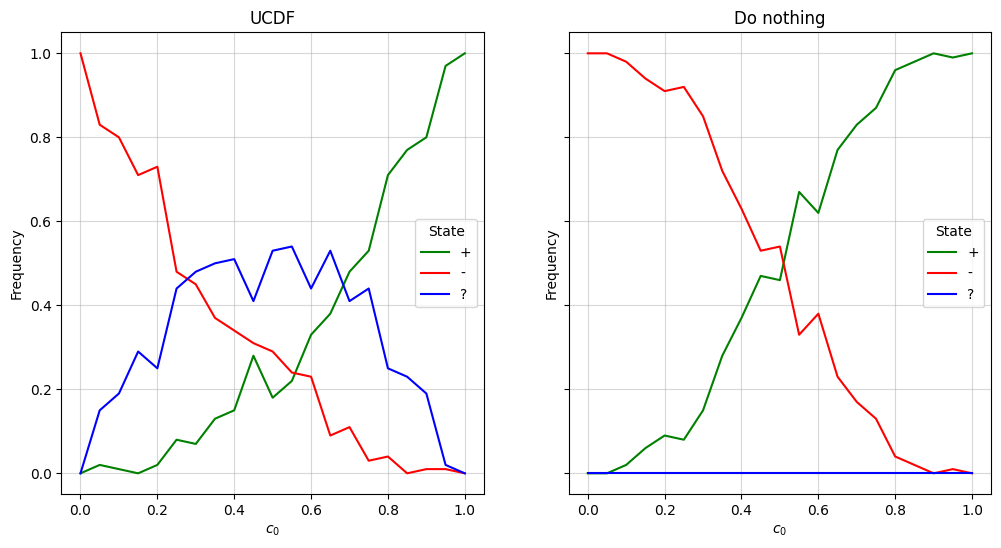

In [57]:
task3()

In [21]:
def task4(alphas: list[float]):
    ns = [100, 200, 400]
    runs = []
    rows, cols = len(alphas) + 1, 2
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), sharey=False, sharex=True)
    for idx, n in enumerate(ns):
        runs.append(
            _get_steps_unitl_steady_state(n, pickle_path=f"data/l1t4_n{n}.pkl")
        )
        ucdf_mean_times = dict(map(lambda kv: (kv[0], np.mean(kv[1])), runs[idx]["ucdf"].items()))
        dn_mean_times = dict(map(lambda kv: (kv[0], np.mean(kv[1])), runs[idx]["dn"].items()))
        ax_ucdf = axs.flatten()[0]
        ax_dn = axs.flatten()[1]
        _plot_from_dict(ucdf_mean_times, ax_ucdf, label = n)
        _plot_from_dict(dn_mean_times, ax_dn, label=n)

        for row, a in enumerate(alphas):
            ucdf_scaled_mean_times = {k: np.mean(v) / (n ** a) for k, v in runs[idx]["ucdf"].items()}
            dn_scaled_mean_times = {k: np.mean(v) / (n ** a) for k, v in runs[idx]["dn"].items()}
            ucdf_scaled_ax = axs[row + 1, 0]
            dn_scaled_ax = axs[row + 1, 1]
            _plot_from_dict(ucdf_scaled_mean_times, ucdf_scaled_ax, label=n)
            _plot_from_dict(dn_scaled_mean_times, dn_scaled_ax, label=n)

    for idx, ax in enumerate(axs.flatten()):
        if idx % 2:
            ax.set_ylabel("Steps")
        ax.legend(title="Size")
        ax.grid(alpha=.5)
        if idx > 1:
            label = alphas[int(idx // 2) - 1]
            ax.set_title(f"$\\alpha={np.round(label,2)}$")
    ax_ucdf.set_title("UCDF")
    ax_dn.set_title("Do nothing")
    axs[len(alphas), 0].set_xlabel("$c_0$")
    axs[len(alphas), 1].set_xlabel("$c_0$")
    return runs

@with_pickle()
def _get_steps_unitl_steady_state(n: int):
    buffer_size = 100
    c_inits = np.arange(0.0, 1.01, 0.05)
    runs_count = 100
    runs_ucdf = defaultdict(list)
    runs_dn = defaultdict(list)
    for c in c_inits:
        print(f"Running simulations for c={c}...")
        model_ucdf = SznajdModel_v3(n=n, t=buffer_size, c0=c)
        model_dn = SznajdModel_v4(n=n, t=buffer_size, c0=c)
        for _ in tqdm(range(runs_count)):
            model_ucdf.run_since_steady()
            runs_ucdf[c].append(model_ucdf.steps_since_steady)
        for _ in tqdm(range(runs_count)):
            model_dn.run_since_steady()
            runs_dn[c].append(model_dn.steps_since_steady)
    return {"dn":runs_dn, "ucdf": runs_ucdf}

def _plot_from_dict(data, ax, *args, **kwargs):
    xs, ys = data.keys(), data.values()
    ax.plot(xs, ys, *args, **kwargs)

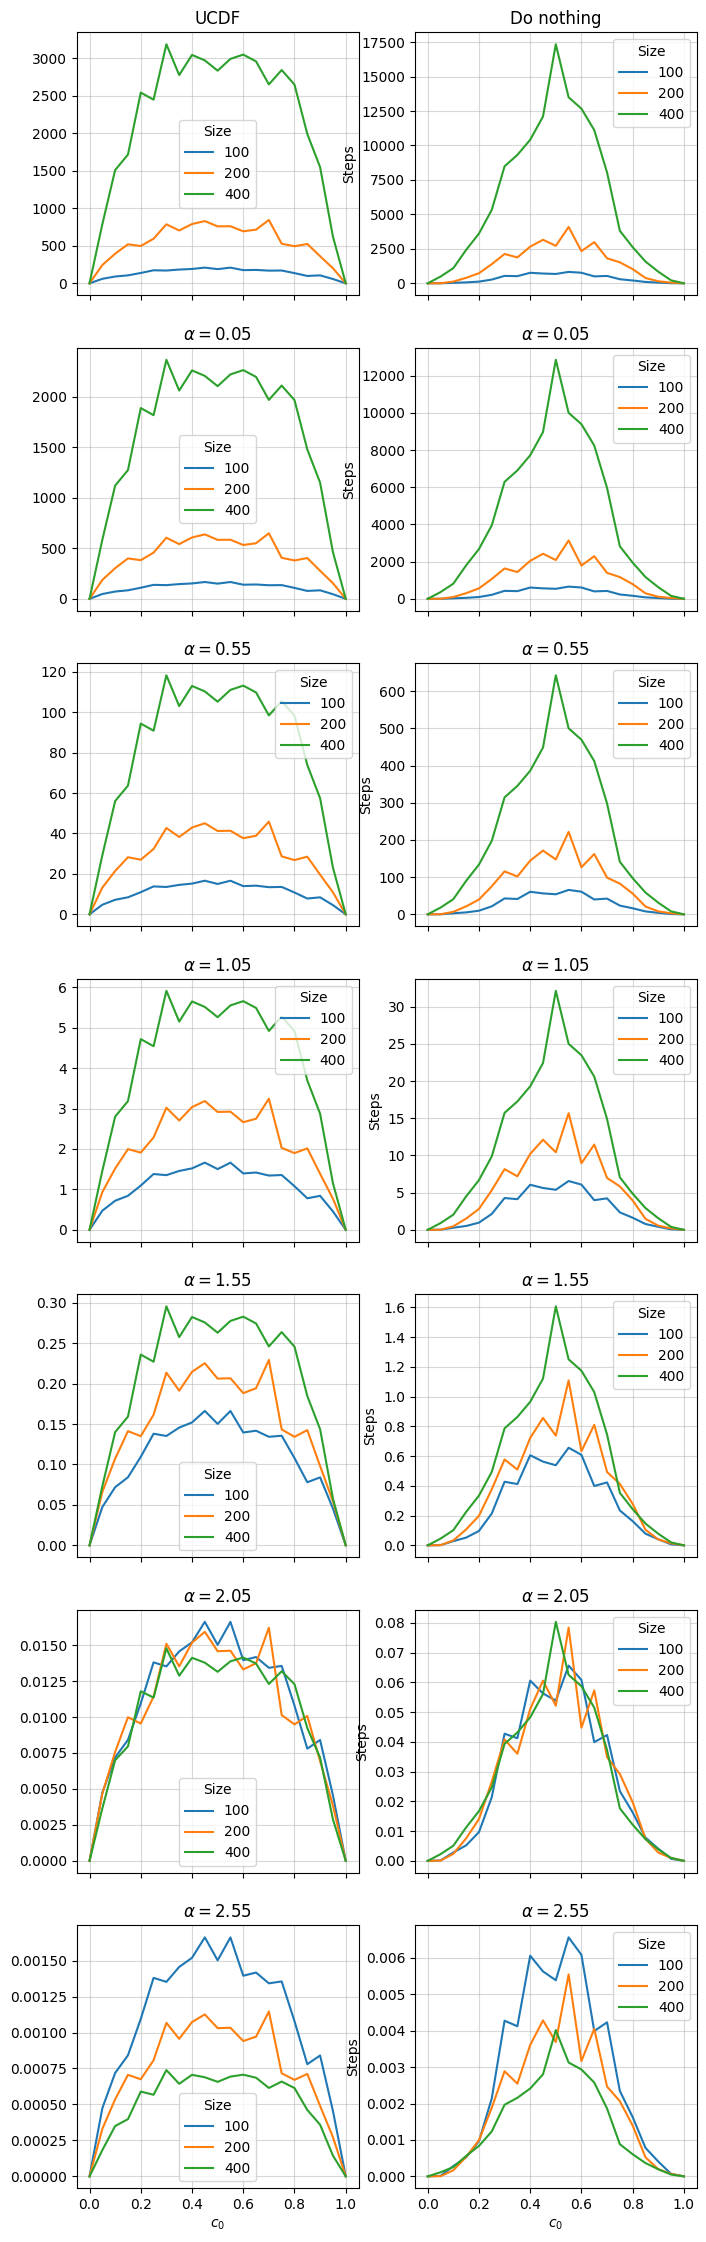

In [24]:
out = task4(np.arange(0.05, 3.01, 0.5))